# Siamese Networks

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Reshape, UpSampling2D, Activation
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.callbacks import EarlyStopping
from PIL import Image
from keras.utils import to_categorical
from keras import backend as K
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import cv2
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import seaborn as sns
import urllib
from pathlib import Path
from tqdm.notebook import tqdm
import pickle
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [34]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.losses import binary_crossentropy
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [35]:
def plot_loss(history):
  n_epochs = max(history.epoch)+1
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  epochs = range(1,n_epochs+1)
  fig, ax = plt.subplots(figsize=(18,6))
  ax = sns.lineplot(x=epochs, y=loss_train,  label='training loss')
  ax = sns.lineplot(x=epochs, y=loss_val,  label='validation loss')
  ax.grid(color='black', linestyle='-', linewidth=0.1)
  ax.set_xticks(np.arange(1,n_epochs,2))
  ax.set_xlim(1)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# Siamese Networks on Intel images data

In [36]:
# To read the pickles we can do this:
with open(os.path.join("/content", "drive", "MyDrive", "data", "intel", "x_train.p"), "rb") as f:
    x_train = pickle.load(f)
with open(os.path.join("/content", "drive", "MyDrive", "data", "intel", "x_test.p"), "rb") as f:
    x_test = pickle.load(f)
with open(os.path.join("/content", "drive", "MyDrive", "data", "intel", "y_train.p"), "rb") as f:
    y_train = pickle.load(f)
with open(os.path.join("/content", "drive", "MyDrive", "data", "intel", "y_test.p"), "rb") as f:
    y_test = pickle.load(f)

In [37]:
classes_dict = {0: 'Buildings', 1: 'Forest', 2: 'Glacier',
                3: 'Mountains', 4: 'Sea', 5: 'Street'}

In [38]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(14034, 128, 128, 3)
(3000, 128, 128, 3)
(14034, 6)
(3000, 6)


In [39]:
x_train = x_train.astype('float32')
x_train /= 255
x_test = x_test.astype('float32')
x_test /= 255

We define a Siamese Network for use with the Intel images dataset. The data set may not be the best for this particular task, since we already have hundreds of examples of each class. But since it is the data we have been using lately we can continue and try siamese networks on it. 

The architecture is similar to that in the paper (Koch et al., "Siamese Neural Networks for One-shot Image Recognition"), but we include dropout and batch normalization to improve generalization and speed up training.

Each siamese "leg" is a convnet that transforms data to a 4096-dimensional representation. The metric we are trying to learn is the L1-distance between such representations. The output of the full Siamese Network represents the probability that the two input images are "similar" (in this case: of the same class)

In [72]:
input_shape = (128, 128, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)
# build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(128, (7,7), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(256, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(Flatten())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3)))
convnet.summary()

# encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# merge two encoded inputs with the L1 distance between them, and connect to prediction output layer
L1_distance = lambda x: K.abs(x[0]-x[1])
both = Lambda(L1_distance)([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(both)
siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)

siamese_net.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 119, 119, 64)      19264     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 59, 59, 64)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 59, 59, 64)        256       
_________________________________________________________________
dropout_20 (Dropout)         (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 53, 53, 128)       401536    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 26, 26, 128)      

In [41]:
print(x_train.shape)
x_train_short = x_train[:1200,:,:,:]
y_train_short = y_train[:1200,:]
x_val = x_train[1200:2000,:]
y_val = y_train[1200:2000,:]

(14034, 128, 128, 3)


In [42]:
x_test.shape

(3000, 128, 128, 3)

To be able to train the Siamese Network we need to do a bit more work than for a simple classification network. We cannot simply feed the full dataset into the network batch by batch, instead here we need pairs of examples. These should be positive examples (where both images are from the same class, with a target output of 1) and negative examples (where the two input images are from a different class, with a target output of 0).

To achieve this, we define the "get_batch" function which selects a number of pairs, half of them with images from the same class, and half of them with images from two different classes.

We also define a generator function "batch_generator" that will repeatedly generate batches using "get_batch", such that we can use it for training with Keras's "fit_generator" method.

In [43]:
labels_train=[]
for i in range(len(y_train_short)):
  labels_train.append(pd.Series(y_train_short[i]).idxmax(axis=1))

labels_val=[]
for i in range(len(y_val)):
  labels_val.append(pd.Series(y_val[i]).idxmax(axis=1))

labels_test=[]
for i in range(len(y_test)):
  labels_test.append(pd.Series(y_test[i]).idxmax(axis=1))

In [44]:
def get_batch(batch_size, X, Y, labels):
    """Create batch of n pairs, half same class, half different class"""

    categories = np.random.choice(6, size=(batch_size,))
    pairs = [np.zeros((batch_size, 128, 128, 3)) for i in range(2)]
    examples = [np.zeros((batch_size, )) for i in range(2)]
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for z in range(int(batch_size)):
      category = categories[z]
      if z<batch_size/2:
        indices = [i for i, x in enumerate(labels) if x == category]
        m = np.random.choice(indices)
        n = np.random.choice(indices)
        pairs[0][z, :, :, :] = X[m]
        pairs[1][z, :, :, :] = X[n]
        examples[0][z]=m
        examples[1][z]=n

      else:
        indices1 = [i for i, x in enumerate(labels) if x == category]
        indices2 = [i for i, x in enumerate(labels) if x != category]
        m = np.random.choice(indices1)
        n = np.random.choice(indices2)
        pairs[0][z, :, :, :] = X[m]
        pairs[1][z, :, :, :] = X[n]
        examples[0][z]=m
        examples[1][z]=n

    return pairs, targets, examples

def batch_generator(X, Y, labels, batch_size):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets, examples = get_batch(batch_size, X, Y, labels)
        yield (pairs, targets)

In [73]:
#opt = keras.optimizers.Adam(learning_rate=0.0025)
siamese_net.compile(loss="binary_crossentropy", optimizer="adam")

In [74]:
history = siamese_net.fit_generator(batch_generator(x_train_short, y_train_short, labels_train, batch_size=100), 
                          validation_data=batch_generator(x_val, y_val, labels_val, batch_size=100),
                          validation_steps=40,
                          steps_per_epoch=100, epochs=7)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/7
100/100 [==============================] - 41s 388ms/step - loss: 6.0584 - val_loss: 2.2525
Epoch 2/7
100/100 [==============================] - 38s 385ms/step - loss: 1.6817 - val_loss: 1.2517
Epoch 3/7
100/100 [==============================] - 38s 383ms/step - loss: 1.0323 - val_loss: 1.0946
Epoch 4/7
100/100 [==============================] - 38s 384ms/step - loss: 0.8880 - val_loss: 1.0434
Epoch 5/7
100/100 [==============================] - 38s 384ms/step - loss: 0.8544 - val_loss: 0.9658
Epoch 6/7
100/100 [==============================] - 38s 384ms/step - loss: 0.8512 - val_loss: 0.9629
Epoch 7/7
100/100 [==============================] - 38s 385ms/step - loss: 0.8605 - val_loss: 0.9695


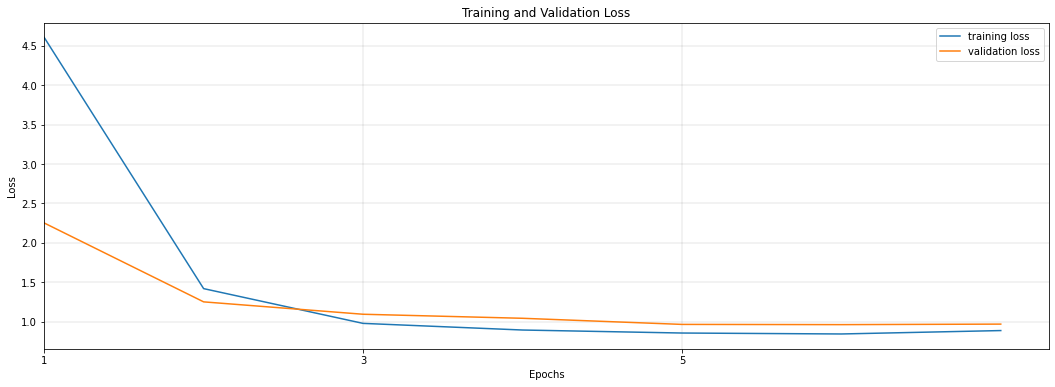

In [75]:
plot_loss(history)

Predict the probability of two input images belonging to the same class:

In [76]:
pairs, targets, examples = get_batch(250, x_test, y_test, labels_test)

In [77]:
preds = siamese_net.predict(pairs)
preds_ = [1 if x>0.5 else 0 for x in preds]

In [78]:
diff = abs(preds_-targets)
1 - diff.mean()

0.6719999999999999

We get it right 67% of the time, not great.

# Examples!

Ground-Truth: DIFFERENT CLASS
Prediction: DIFFERENT CLASS
Prob. of same class:  10.36 %


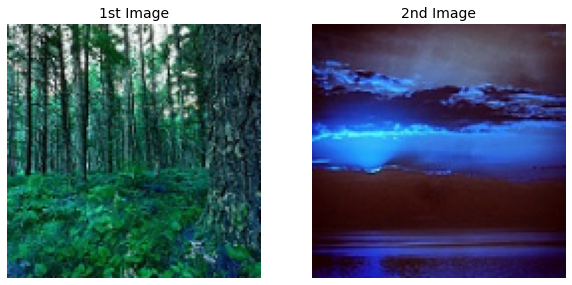

In [84]:
fig, ax = plt.subplots(figsize=(10,10))
i = np.random.randint(1,len(preds))
plt.subplot(1,2,1)
plt.imshow(x_test[int(examples[0][i])])
plt.axis('off')
plt.title('1st Image', fontsize=14)
plt.subplot(1,2,2)
plt.imshow(x_test[int(examples[1][i])])
plt.axis('off')
plt.title('2nd Image', fontsize=14)
if int(targets[i])==0:
  print("Ground-Truth: SAME CLASS")
else:
  print("Ground-Truth: DIFFERENT CLASS")
if int(preds_[i])==0:
  print("Prediction: SAME CLASS")
else:
  print("Prediction: DIFFERENT CLASS")
print("Prob. of same class: ", round(100-preds[i][0]*100,2),"%")


Ground-Truth: DIFFERENT CLASS
Prediction: DIFFERENT CLASS
Prob. of same class:  4.89 %


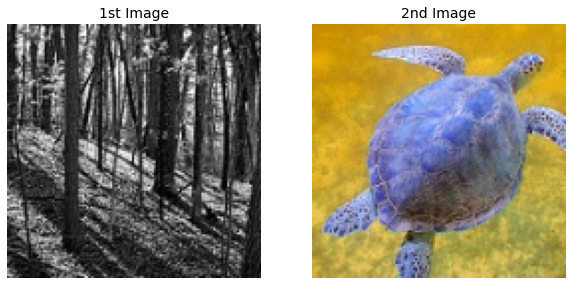

In [82]:
fig, ax = plt.subplots(figsize=(10,10))
i = np.random.randint(1,len(preds))
plt.subplot(1,2,1)
plt.imshow(x_test[int(examples[0][i])])
plt.axis('off')
plt.title('1st Image', fontsize=14)
plt.subplot(1,2,2)
plt.imshow(x_test[int(examples[1][i])])
plt.axis('off')
plt.title('2nd Image', fontsize=14)
if int(targets[i])==0:
  print("Ground-Truth: SAME CLASS")
else:
  print("Ground-Truth: DIFFERENT CLASS")
if int(preds_[i])==0:
  print("Prediction: SAME CLASS")
else:
  print("Prediction: DIFFERENT CLASS")
print("Prob. of same class: ", round(100-preds[i][0]*100,2),"%")


Ground-Truth: SAME CLASS
Prediction: SAME CLASS
Prob. of same class:  72.38 %


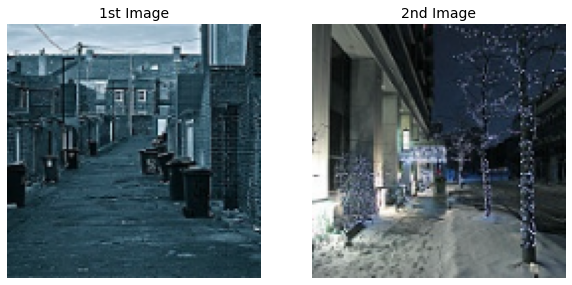

In [86]:
fig, ax = plt.subplots(figsize=(10,10))
i = np.random.randint(1,len(preds))
plt.subplot(1,2,1)
plt.imshow(x_test[int(examples[0][i])])
plt.axis('off')
plt.title('1st Image', fontsize=14)
plt.subplot(1,2,2)
plt.imshow(x_test[int(examples[1][i])])
plt.axis('off')
plt.title('2nd Image', fontsize=14)
if int(targets[i])==0:
  print("Ground-Truth: SAME CLASS")
else:
  print("Ground-Truth: DIFFERENT CLASS")
if int(preds_[i])==0:
  print("Prediction: SAME CLASS")
else:
  print("Prediction: DIFFERENT CLASS")
print("Prob. of same class: ", round(100-preds[i][0]*100,2),"%")
